In [11]:
# Geopandas
import geopandas as gpd
# Inline plots
%matplotlib inline

Geopandas is a very useful library for geographic manipulations. It also includes some datasets, among which we have one with world countries:

In [12]:
# Read countries
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))    # already in geopandas
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


Let us filter the European countries, and index the dataframe by country name:

In [13]:
# European countries
eur_countries = countries.loc[countries['continent'] == 'Europe'].set_index('name')
print(len(eur_countries))
eur_countries.head()

39


,pop_est,continent,iso_a3,gdp_md_est,geometry
name,,,,,
Albania,3639453.0,Europe,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
Austria,8210281.0,Europe,AUT,329500.0,"POLYGON ((16.97966678230404 48.12349701597631,..."
Belgium,10414336.0,Europe,BEL,389300.0,"POLYGON ((3.314971144228537 51.34578095153609,..."
Bulgaria,7204687.0,Europe,BGR,93750.0,"POLYGON ((22.65714969248299 44.23492300066128,..."
Bosnia and Herz.,4613414.0,Europe,BIH,29700.0,"POLYGON ((19.00548628101012 44.86023366960916,..."


Only 39 countries in Europe? Well, it turns out that this dataset does not include small ones, such as Andorra, Monaco, Liechtenstein, San Marino, etc. Anyway, let's add a column with a flag stating whether I've been to these countries or not:

In [14]:
# Ask myself whether I've been to these countries, and store answer
for c in eur_countries.index:
    ans = input(prompt="Have you been to {}? (y/n) ".format(c))
    eur_countries.loc[c, 'been_to'] = ans

Have you been to Albania? (y/n) n
Have you been to Austria? (y/n) y
Have you been to Belgium? (y/n) y
Have you been to Bulgaria? (y/n) y
Have you been to Bosnia and Herz.? (y/n) y
Have you been to Belarus? (y/n) n
Have you been to Switzerland? (y/n) y
Have you been to Czech Rep.? (y/n) y
Have you been to Germany? (y/n) y
Have you been to Denmark? (y/n) y
Have you been to Spain? (y/n) y
Have you been to Estonia? (y/n) n
Have you been to Finland? (y/n) n
Have you been to France? (y/n) y
Have you been to United Kingdom? (y/n) y
Have you been to Greece? (y/n) y
Have you been to Croatia? (y/n) y
Have you been to Hungary? (y/n) y
Have you been to Ireland? (y/n) y
Have you been to Iceland? (y/n) n
Have you been to Italy? (y/n) y
Have you been to Kosovo? (y/n) n
Have you been to Lithuania? (y/n) n
Have you been to Luxembourg? (y/n) y
Have you been to Latvia? (y/n) n
Have you been to Moldova? (y/n) n
Have you been to Macedonia? (y/n) n
Have you been to Montenegro? (y/n) y
Have you been to Nethe

And check that the column has been added:

In [15]:
eur_countries.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,been_to
name,,,,,,
Albania,3639453.0,Europe,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",n
Austria,8210281.0,Europe,AUT,329500.0,"POLYGON ((16.97966678230404 48.12349701597631,...",y
Belgium,10414336.0,Europe,BEL,389300.0,"POLYGON ((3.314971144228537 51.34578095153609,...",y
Bulgaria,7204687.0,Europe,BGR,93750.0,"POLYGON ((22.65714969248299 44.23492300066128,...",y
Bosnia and Herz.,4613414.0,Europe,BIH,29700.0,"POLYGON ((19.00548628101012 44.86023366960916,...",y


Cool! Geopandas also allows us to plot this using a column to decide on colors. For example, let's plot the countries I've been to in blue, and those I haven't been to yet in red:

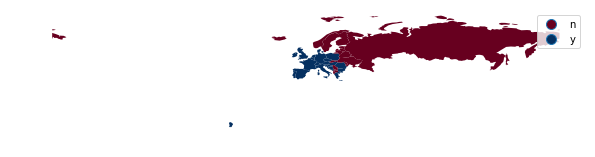

In [16]:
def plot_geodf(df, plot_args):
    return df.plot(**plot_args).set_axis_off()     # axis off not to show coordinates
plot_params = {'column':'been_to', 'cmap':'RdBu', 'legend':True, 'figsize':(10, 10)}
plot_geodf(eur_countries, plot_params)

Hey, wait! What's going on here? Well, first we have that Russia is enormous. If we get rid of it:

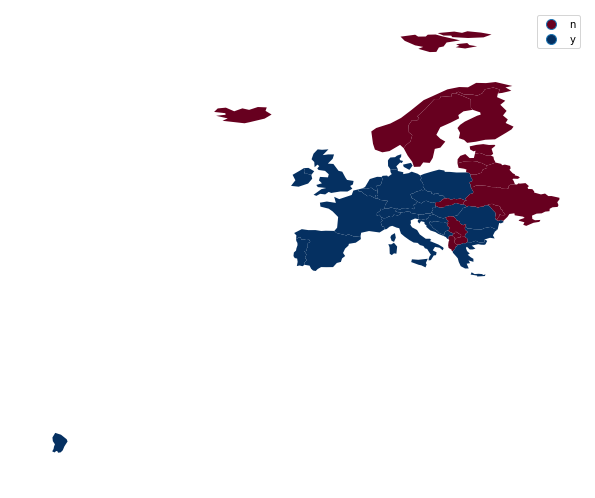

In [17]:
plot_geodf(eur_countries[eur_countries['iso_a3'] != 'RUS'], plot_params)

Better, but we still have French Guiana down there! How do we keep the European part of Russia, while also remove Guiana without removing France? Well, a quick and dirty solution is to compute the bounding box of the rest of countries. Geopandas makes this easy: 

In [18]:
# Rectangular boundary without France and Russia
bounds = eur_countries[(eur_countries['iso_a3'] != 'FRA') & (eur_countries['iso_a3'] != 'RUS')].unary_union.envelope
print(bounds)

POLYGON ((-24.32618404793934 34.91998769788961, 40.08078901546935 34.91998769788961, 40.08078901546935 80.6571442735935, -24.32618404793934 80.6571442735935, -24.32618404793934 34.91998769788961))


Quick explanation of the above: we select all countries except France and Russia, mix their geometries into a single polygon (unary union), and then compute the envelope of this pan-European polygon. Note that it is a rectangle.

And now, for each country we can modify its geometry, so that it keeps only the part inside the envelope. By the way we computed this envelope, all countries will remain the same except for Russia and France. To keep things clear, we store the result in another dataframe:

In [19]:
# Intersection with boundary
aux = eur_countries.intersection(bounds)
eur_countries_cropped = eur_countries.copy()
eur_countries_cropped.geometry = aux.geometry
eur_countries_cropped.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,been_to
name,,,,,,
Albania,3639453.0,Europe,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",n
Austria,8210281.0,Europe,AUT,329500.0,"POLYGON ((16.97966678230404 48.12349701597631,...",y
Belgium,10414336.0,Europe,BEL,389300.0,"POLYGON ((3.314971144228537 51.34578095153609,...",y
Bulgaria,7204687.0,Europe,BGR,93750.0,"POLYGON ((22.65714969248299 44.23492300066128,...",y
Bosnia and Herz.,4613414.0,Europe,BIH,29700.0,"POLYGON ((19.00548628101012 44.86023366960916,...",y


So let's plot again:

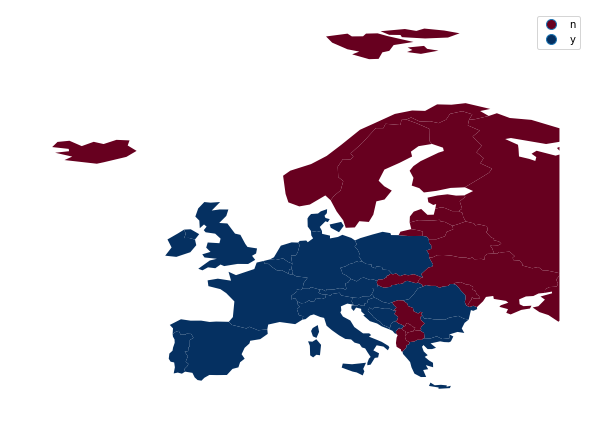

In [20]:
# Final result
plot_geodf(eur_countries_cropped, plot_params)

We got it!